<h1>Dataset</h1>

<p>We will start by importing all requied libraries needed for this project.</p>

In [1]:
import os
import numpy as np
import pandas as pd
import polars as pl
import re

# Dimensionality Reduction
from scipy.sparse import csr_matrix
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.manifold import TSNE
import umap
import umap.plot

# Clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

# Plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Calculations
from scipy.stats import zscore
from sklearn.preprocessing import PowerTransformer

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.N

<h3>Load Data</h3>
<p>Loading in both of our datasets from local files.</p>

In [2]:
demo_stats_df = pl.read_csv("Coursework Data/DemoStats.csv", null_values=None)
household_spend_df = pl.read_csv("Coursework Data/HouseholdSpend.csv", null_values=None)

<h3>Merging Data</h3>
<p>Next, we will combine these two datasets into one. We joined them on the "CODE" column, which is the common column between the two datasets.</p>

In [3]:
merged_df = demo_stats_df.join(
    household_spend_df,
    on=["CODE"],
    how="inner"
)

# Drop ID columns
merged_df = merged_df.drop(["GEO", "CODE"])

# Describe the data
merged_df.describe()

statistic,ECYASQKM,ECYALSQKM,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,ECYPTA7074,ECYPTA7579,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.0,0.0,46.684199,18.432629,45.881762,41.254934,39.613594,37.819792,37.323999,40.336732,38.832472,37.263988,36.746572,3.072744,24.49923,12.76093,12.051364,12.740845,24.633679,46.684199,2.181318,2.390635,2.498651,2.672259,3.213171,3.308621,3.406466,3.258362,3.117668,2.858167,2.776588,2.859335,3.10898,2.80384,2.278714,1.770631,…,236398.761036,118477.006209,114562.677761,14888.288571,8607.895903,91066.493288,188.957063,83.539013,105.41805,3725.371385,3469.552047,2092.59778,1376.954267,255.819338,1504.664209,116417.090618,3287.664753,10103.061471,12676.188385,18214.142317,100.530695,63415.559732,2639.560863,4612.181943,1368.200459,379.01064,989.189819,34736.610626,5995.306708,2258.469958,915.416319,23038.220756,71.1409,1322.434304,831.592595,490.84171,1135.621681
"""std""",0.0,0.0,174.837877,69.379951,171.817976,152.539099,145.876662,139.320601,137.611402,149.038058,143.038376,137.181937,135.319262,12.468123,87.647782,50.126862,47.828225,49.02113,89.352097,174.837877,9.518254,10.400337,10.705186,10.30089,10.888878,10.894537,11.699239,11.371185,11.099312,10.485757,10.544898,11.657788,13.69638,12.729886,10.420684,8.140557,…,990960.632583,507452.95803,494184.487741,58848.760548,45895.371562,398856.15598,794.022208,358.55285,497.256289,14112.764792,13213.369738,8173.498909,5705.767025,1422.161917,5673.303299,486744.921092,14400.182837,39378.141535,60281.31644,71889.568827,615.785308,284702.777168,13567.714202,14917.235034,5725.037991,2091.296014,3882.026395,101629.434794,19414.670337,7613.821326,5037.673958,71509.135272,257.018871,6638.799848,5076.885882,2097.649493,4203.801021
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",0.0,0.0,8.0,3.0,7.0,7.0,7.0,6.0,6.0,7.0,7.0,6.0,6.0,0.0,4.0,2.0,2.0,2.0,4.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

<p>The data is now merged. One thing that stands out to me is the extreme values at each end of the distribution. We will need to take a look at these values and see if they are valid or if they are outliers. We will do this later.</p>

<h1>Part 1: Clustering and Dimensionality Reduction</h1>

The first part of the coursework will focus
on identifying the characteristics of Canadian households, excluding their pension
behaviour. For this, do not include, in your clustering and dimensionality reduction models,
the target of the regression model in Part 2.

In [4]:
# Drop target variable
merged_df_clust = merged_df.drop("HSEP001S")

<h3>Null Values</h3>
<p>We will check for any null values in our dataset. If there are any, we will need to decide on how to handle them.</p>
<p>From doing a quick scan of the database, it seems null values are listed as string of "NA"s. We will need to convert these to actual null values.</p>

In [5]:
total_data_points = merged_df_clust.height
print(f"Total data points: {total_data_points}")
# Define a function to convert NA to None
def convert_na_to_nulls(df):
    return df.with_columns([
        pl.col(col).replace("NA", None).alias(col)
        if df.schema[col] == pl.Utf8 else pl.col(col)
        for col in df.columns
    ])

# Convert NA to None on both dataframes
merged_df_clust = convert_na_to_nulls(merged_df_clust)

# Get total nulls for each column
def count_na_strings(df):
    total_rows = df.height
    return {
        col: {
            "null_count": df[col].null_count(),
            "less than 1%": 1 / total_rows < 0.01,
        }
        for col in df.columns
        if df[col].null_count() > 0
    }

merged_df_nulls = count_na_strings(merged_df_clust)
print(f"Data Null Count: {merged_df_nulls}")

Total data points: 868970
Data Null Count: {'ECYPTAMED': {'null_count': 87459, 'less than 1%': True}, 'ECYPMAMED': {'null_count': 96444, 'less than 1%': True}, 'ECYPFAMED': {'null_count': 131837, 'less than 1%': True}, 'ECYHTAMED': {'null_count': 92709, 'less than 1%': True}, 'ECYHMAMED': {'null_count': 101698, 'less than 1%': True}, 'ECYHFAMED': {'null_count': 137900, 'less than 1%': True}, 'ECYMTNMED': {'null_count': 92709, 'less than 1%': True}}


In [6]:
# Function to turn any string into a number
def convert_strings_to_numbers(df):
    if hasattr(df, "to_pandas"):
        df = df.to_pandas()

    for col in df.columns:
        if col in ["CODE", "GEO"]:
            continue  # skip explicitly excluded columns

        if df[col].dtype == "object" or pd.api.types.is_string_dtype(df[col]):
            if (df[col] == "NA").any():
                continue  # skip if "NA" appears in the column
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                df[col] = df[col].astype("category").cat.codes

    return pl.from_pandas(df)

# Convert df
merged_df_clust = convert_strings_to_numbers(merged_df_clust)

<p>Wow, we have a lot of null values in our dataset. However, after a quick inspection, it seems a lot of these null values are soley from rows that contain only zero. Here is an example...</p>

In [7]:
# Display entire row
def display_row(df, row_index):
    df = df.to_pandas()
    with pd.option_context(
        'display.max_columns', None,
        'display.max_colwidth', None,
        'display.width', None,
        'display.expand_frame_repr', False
    ):
        row = df.iloc[row_index]
        print(row.to_string())
    return row

row = display_row(merged_df_clust, 461)

ECYASQKM       0.0
ECYALSQKM      0.0
ECYBASPOP      0.0
ECYBASHHD      0.0
ECYBASHPOP     0.0
ECYBAS12P      0.0
ECYBAS15P      0.0
ECYBAS18P      0.0
ECYBAS19P      0.0
ECYBAS12HP     0.0
ECYBAS15HP     0.0
ECYBAS18HP     0.0
ECYBAS19HP     0.0
ECYBASTNGH     0.0
ECYBASADUH     0.0
ECYBASCF       0.0
ECYBASCFH      0.0
ECYBASKID      0.0
ECYBASLF       0.0
ECYPTAPOP      0.0
ECYPTA_0_4     0.0
ECYPTA_5_9     0.0
ECYPTA1014     0.0
ECYPTA1519     0.0
ECYPTA2024     0.0
ECYPTA2529     0.0
ECYPTA3034     0.0
ECYPTA3539     0.0
ECYPTA4044     0.0
ECYPTA4549     0.0
ECYPTA5054     0.0
ECYPTA5559     0.0
ECYPTA6064     0.0
ECYPTA6569     0.0
ECYPTA7074     0.0
ECYPTA7579     0.0
ECYPTA8084     0.0
ECYPTA85P      0.0
ECYPTAAVG      0.0
ECYPTAMED      NaN
ECYPMAPOP      0.0
ECYPMA_0_4     0.0
ECYPMA_5_9     0.0
ECYPMA1014     0.0
ECYPMA1519     0.0
ECYPMA2024     0.0
ECYPMA2529     0.0
ECYPMA3034     0.0
ECYPMA3539     0.0
ECYPMA4044     0.0
ECYPMA4549     0.0
ECYPMA5054     0.0
ECYPMA5559  

<h3>Handle Nulls</h3>

<p>That being said, we will need to remove these rows from our dataset. We will do this by removing any rows that contain only zeroes and nulls.</p>

In [8]:
# Remove rows with only nulls or zeros
def remove_rows_with_nulls_or_zeros(df):
    df = df.to_pandas()
    # This mask is True for rows where all **non-null** values are 0
    mask = df.apply(lambda row: (row.dropna() == 0).all(), axis=1)
    df = df[~mask].reset_index(drop=True)
    return pl.from_pandas(df)

merged_df_clust = remove_rows_with_nulls_or_zeros(merged_df_clust)
# Check for any remaining nulls
merged_df_nulls = count_na_strings(merged_df_clust)
print(f"Data Null Count: {merged_df_nulls}")

Data Null Count: {'ECYPMAMED': {'null_count': 8985, 'less than 1%': True}, 'ECYPFAMED': {'null_count': 44378, 'less than 1%': True}, 'ECYHTAMED': {'null_count': 5250, 'less than 1%': True}, 'ECYHMAMED': {'null_count': 14239, 'less than 1%': True}, 'ECYHFAMED': {'null_count': 50441, 'less than 1%': True}, 'ECYMTNMED': {'null_count': 5250, 'less than 1%': True}}


<p>That definitely helped. We still have some nulls values but not as many. For the rest, we can substitute them with the median of the column. This is a common practice in data science and will help us keep our dataset clean.</p>

In [9]:
def substitute_nulls_with_median(df: pl.DataFrame) -> pl.DataFrame:
    # Convert to Pandas
    df_pd = df.to_pandas()

    for col in df_pd.columns:
        if pd.api.types.is_numeric_dtype(df_pd[col]):
            if df_pd[col].isnull().sum() > 0:
                median = df_pd[col].median()
                print(f"Filling nulls in '{col}' with median = {median}")
                df_pd[col] = df_pd[col].fillna(median)

    # Back to Polars
    return pl.from_pandas(df_pd)


merged_df_clust = substitute_nulls_with_median(merged_df_clust)

merged_df_nulls = count_na_strings(merged_df_clust)
print(f"Data Null Count: {merged_df_nulls}")

Filling nulls in 'ECYPMAMED' with median = 40.0
Filling nulls in 'ECYPFAMED' with median = 42.5
Filling nulls in 'ECYHTAMED' with median = 41.1
Filling nulls in 'ECYHMAMED' with median = 40.0
Filling nulls in 'ECYHFAMED' with median = 42.5
Filling nulls in 'ECYMTNMED' with median = 55.0
Data Null Count: {}


<h3>Negative Values</h3>

In [10]:
# Get total negative values for each column
def count_negative_values(df):
    return {
        col: {
            "negative_count": df[col].filter(df[col] < 0).len(),
        }
        for col in df.columns
        if df.schema[col] in [pl.Int8, pl.Int16, pl.Int32, pl.Int64,
                              pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                              pl.Float32, pl.Float64]
        and df[col].filter(df[col] < 0).len() > 0
    }

# Get total negative values for each dataframe
merged_df_negatives = count_negative_values(merged_df_clust)
print(f"Data Negative Values Count: {merged_df_negatives}")

Data Negative Values Count: {'HSTT001': {'negative_count': 28}, 'HSTE001ZBS': {'negative_count': 163557}, 'HSWH040S': {'negative_count': 255858}, 'HSWH041S': {'negative_count': 15436}, 'HSWH042S': {'negative_count': 19205}}


<p>We can see that there are negative values in the dataset:<p>
<ul>
<li>HSTT001 - Total expenditure,Household Expenditures (Category Summary),Dollars</li>
<li>HSTE001ZBS - Total non-current consumption,Household Expenditures (Category Summary),Dollars</li>
<li>HSWH040S,Net purchase price of owned residences,Household Expenditures (Category Summary),Dollars</li>
<li>HSWH041S - Net purchase price of owned secondary residences,Household Expenditures (Category Summary),Dollars</li>
<li>HSWH042S - Net purchase price of other owned properties,Household Expenditures (Category Summary),Dollars</li>
</ul>
<p>We can easily tell that the first two varaibles cannot be negative, since they desribe expenditures, and because they capture sums of outflows. The next 3 are tricky, because these variables reflect the net purchase price of owned residences, secondary residences, and other properties, they can indeed be negative if the proceeds from selling those properties exceed any purchase or improvement costs, thereby indicating a net inflow rather than an outflow.</p>
<p>Therefore, we will remove the negatives in the first two variables, and keep the last three.</p>

In [ ]:
def remove_negative_rows(df, cols):
    updated_df = df.clone()

    for col in cols:
        if col in df.columns:
            neg_count = df.select((pl.col(col) < 0).sum()).item()

            if neg_count > 0:
                print(f"Removing {neg_count} rows with negative values in '{col}'")
                updated_df = updated_df.filter(pl.col(col) >= 0)
    return updated_df

# Replace negative values with median
merged_df_clust = remove_negatives_with_median(merged_df_clust, ["HSTT001", "HSTE001ZBS"])
merged_df_negatives = count_negative_values(merged_df_clust)
print(f"Data Negative Values Count: {merged_df_negatives}")

Replacing 28 negative values in 'HSTT001' with median = 1165481.55949622
Replacing 163557 negative values in 'HSTE001ZBS' with median = 124429.66117
Data Negative Values Count: {'HSWH040S': {'negative_count': 255858}, 'HSWH041S': {'negative_count': 15436}, 'HSWH042S': {'negative_count': 19205}}


<h3>General Clean Up</h3>
<p>Here, we will be cleaning up any data that is redundant, such as rows with straight zeros, columns where the mean and std are both zero, implying that the column is constant, and any other data that is not useful.</p>

In [12]:
# Drop any rows that contain straight 0's in all columns
columns_to_check = [col for col in merged_df_clust.columns if merged_df_clust.schema[col] in (pl.Int64, pl.Float64)]
merged_df_clust = merged_df_clust.filter(
    ~pl.all_horizontal([pl.col(col) == 0 for col in columns_to_check])
)

# Drop any columns where the mean and std are both 0
columns_to_drop = [
    col for col in merged_df_clust.columns
    if merged_df_clust.schema[col] in (pl.Int64, pl.Float64)
    and merged_df_clust[col].mean() == 0
    and merged_df_clust[col].std() == 0
]
merged_df_clust = merged_df_clust.drop(columns_to_drop)


merged_df_clust.describe()

statistic,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,ECYPTA7074,ECYPTA7579,ECYPTA8084,ECYPTA85P,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,…,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",51.908633,20.495427,51.016396,45.871779,44.046757,42.05221,41.500932,44.850821,43.178219,41.434206,40.858886,3.416615,27.240942,14.189007,13.400034,14.166675,27.390437,51.908633,2.42543,2.658171,2.778276,2.971312,3.572757,3.678889,3.787684,3.623006,3.466567,3.178024,3.087317,3.179323,3.456906,3.117618,2.533725,1.968782,1.236853,1.187994,…,262854.17784,131735.783739,127383.402273,16554.438926,9571.206679,101257.756669,210.103273,92.887875,117.215398,4142.278193,3857.830079,2326.780676,1531.049403,284.448114,1673.051381,129445.34272,3655.587753,11233.696425,14094.782314,20252.489407,111.781098,70512.403459,2934.95447,5128.331838,1521.315954,421.425771,1099.890184,38623.989343,6666.24228,2511.215631,1017.860681,25616.431106,79.102288,1470.428103,924.656232,545.771871,1262.709255
"""std""",183.624603,72.869667,180.452808,160.188457,153.186764,146.302601,144.50877,156.51093,150.206581,144.055963,142.100319,13.102523,92.017153,52.665326,50.254015,51.495634,93.817681,183.624603,10.007189,10.934389,11.253851,10.821015,11.425931,11.428539,12.277853,11.935374,11.652124,11.01087,11.076073,12.251357,14.400743,13.386815,10.958875,8.561232,5.39964,6.121693,…,1.0416e6,533460.115491,519534.114986,61831.702633,48300.012572,419353.874047,834.616431,376.933616,523.022319,14823.372362,13879.264885,8587.052978,5996.930532,1496.911695,5958.744429,511613.155937,15140.230955,41369.906152,63407.460354,75532.728537,648.359,299376.381415,14276.437421,15645.434509,6017.566002,2201.15558,4078.587111,106462.508615,20362.688317,7988.932656,5302.260033,74965.133946,269.854744,6984.865407,5345.388661,2205.124523,4414.650631
"""min""",1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",11.0,4.0,11.0,10.0,10.0,9.0,9.0,10.0,9.0,9.0,9.0,1.0,6.0,3.0,3.0,2.0,5.0,11.0,0.0,0

<h3>Correlated Variables</h3>
<p>Now, we will be looking for correlated variables. We will be using the correlation matrix to find the correlation between the variables.</p>

<p>Start by removing anything with the word retirement, pension, insurance, premium
except for target column calculation variable</p>
<p>We do this because we are trying to predict the target variable, which is the Total personal insurance premiums and retirement/pension contributions. We want to remove any variables that are correlated with the target variable, so that we can get a better prediction.</p>

In [13]:
columns_to_drop = [
    "ECYINDFINA", "HSEP001", "HSSH006", "HSSH014", "HSSH019", "HSSH044", "HSEP002",
    "HSEP003", "HSEP004", "HSEP005", "HSEP006", "HSEP007", "HSEP008", "HSEP009",
    "HSHC022", "HSHC023", "HSHC024", "HSHC025", "HSTR025", "HSRV011"
]

for col in columns_to_drop:
    if col in merged_df_clust.columns:
        merged_df_clust = merged_df_clust.drop(col)
    else:
        print(f"Column not found: {col}")

Column not found: HSEP001
Column not found: HSEP002
Column not found: HSEP003
Column not found: HSEP004
Column not found: HSEP005
Column not found: HSEP006
Column not found: HSEP007
Column not found: HSEP008
Column not found: HSEP009
Column not found: HSTR025
Column not found: HSRV011


<p>Now, lets create a function to remove perfectly correlated variables. We will be using the correlation matrix to find the correlation between the variables.</p>

In [14]:
def summarize_perfectly_correlated_vars(df):
    numeric_df = df.select(pl.selectors.numeric())
    corr_matrix = numeric_df.corr()
    columns = numeric_df.columns

    correlated_pairs = {
        "var_1": [],
        "var_2": [],
        "correlation": []
    }

    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            corr_value = corr_matrix.select(columns[j]).row(i)[0]
            if corr_value == 1.0 or corr_value == -1.0:
                correlated_pairs["var_1"].append(columns[i])
                correlated_pairs["var_2"].append(columns[j])
                correlated_pairs["correlation"].append(corr_value)

    return pl.DataFrame(correlated_pairs).sort("correlation", descending=True)


# Get highly correlated variables
df_correlated = summarize_perfectly_correlated_vars(merged_df_clust)
print("Df Highly Correlated Variables:", df_correlated)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Df Highly Correlated Variables: shape: (127, 3)
┌────────────┬────────────┬─────────────┐
│ var_1      ┆ var_2      ┆ correlation │
│ ---        ┆ ---        ┆ ---         │
│ str        ┆ str        ┆ f64         │
╞════════════╪════════════╪═════════════╡
│ ECYBASHPOP ┆ ECYHTAHPOP ┆ 1.0         │
│ ECYBASHPOP ┆ ECYHSZTPER ┆ 1.0         │
│ ECYBASHPOP ┆ ECYRELHPOP ┆ 1.0         │
│ ECYBASHPOP ┆ ECYVISHPOP ┆ 1.0         │
│ ECYBASHPOP ┆ ECYAIDHPOP ┆ 1.0         │
│ …          ┆ …          ┆ …           │
│ HSFD001S   ┆ HSFD001    ┆ 1.0         │
│ HSHO001S   ┆ HSHO001    ┆ 1.0         │
│ HSHC001S   ┆ HSHC001    ┆ 1.0         │
│ HSTR001S   ┆ HSTR001    ┆ 1.0         │
│ HSSH012    ┆ HSSH012B   ┆ 1.0         │
└────────────┴────────────┴─────────────┘


<p>We can see that certain variables are highly correlated with other variables, this is because we have a large number of aggregate variables that are derived from the same underlying data. To fix this, we will drop variables with a correlation count of over 1, since these can be determined as having redundancy.</p>

In [15]:
def remove_perfectly_correlated_columns(df: pl.DataFrame) -> tuple[pl.DataFrame, list[str]]:
    numeric_df = df.select(pl.selectors.numeric())
    corr_matrix = numeric_df.corr()
    columns = numeric_df.columns
    to_drop = set()
    already_seen = set()

    for i in range(len(columns)):
        col_i = columns[i]
        if col_i in to_drop:
            continue
        for j in range(i + 1, len(columns)):
            col_j = columns[j]
            if col_j in to_drop:
                continue
            corr_val = corr_matrix.select(col_j).row(i)[0]
            if abs(corr_val) == 1.0 and col_j not in already_seen:
                to_drop.add(col_j)
        already_seen.add(col_i)

    cleaned_df = df.drop(to_drop)
    return cleaned_df, sorted(to_drop)


merged_df_clust, dropped_columns = remove_perfectly_correlated_columns(merged_df_clust)
print(f"Dropped {len(dropped_columns)} highly correlated columns:")
print(dropped_columns)

Dropped 35 highly correlated columns:
['ECYAIDHPOP', 'ECYAIMHPOP', 'ECYAIMNI', 'ECYAIMNPER', 'ECYCFSCF', 'ECYCHAKIDS', 'ECYCHA_5_9', 'ECYCWHPL', 'ECYEDAHPWK', 'ECYEDUHP15', 'ECYGENHPOP', 'ECYHNIAVG', 'ECYHOMHPOP', 'ECYHSZTPER', 'ECYHTAHPOP', 'ECYKNOHPOP', 'ECYMOTHPOP', 'ECYOCCINLF', 'ECYPIM22CY', 'ECYPIMHPOP', 'ECYPIMNI', 'ECYPIMNPER', 'ECYPOWEMP', 'ECYRELHPOP', 'ECYRIMHPOP', 'ECYSTYHHD', 'ECYTCAHPOP', 'ECYTIMHPOP', 'ECYTRAHPL', 'ECYVISHPOP', 'HSFD001', 'HSHC001', 'HSHO001', 'HSSH012B', 'HSTR001']


<h3>Outliers</h3>
<p>One major issue with this data is how skewed it is. The data is heavily skewed to the right, with a very long tail. For example, we are getting values of over 20,000, tailing all the way down to 100, but then the mean of that column will be around 40.</p>

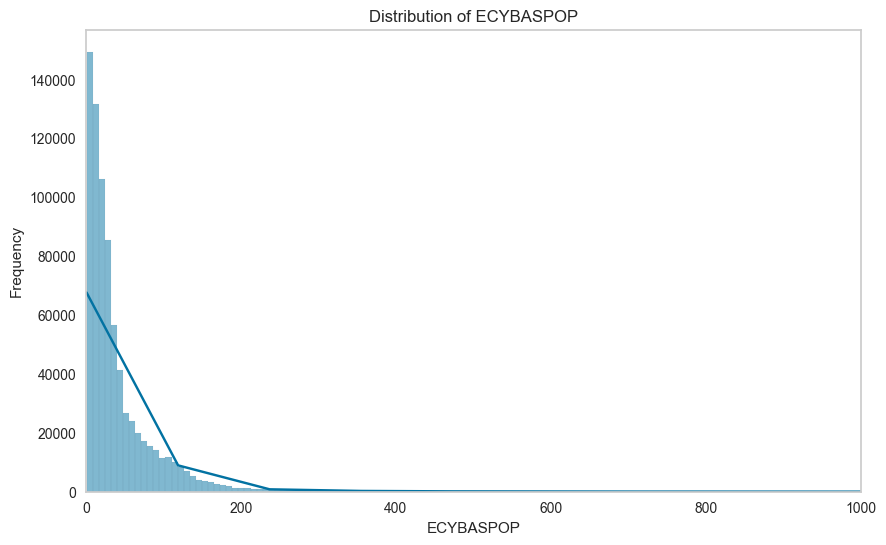

In [16]:
def plot_distribution(df, column, xlim=None, numbins=300):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=numbins, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    if xlim:
        plt.xlim(xlim)
    plt.grid()
    plt.show()

plot_distribution(merged_df_clust, "ECYBASPOP", xlim=(0, 1000), numbins=3000)

<p>You can clearly see how skewed the data is. The mean is around 40, but the median is around 20. This is a clear indication that the data is skewed to the right. We can also see that the data has a long tail that goes past 1000 (it actually goes to 20,000).</p>
<p>To fix this, we will first use a power transform to make the data more normal.</p>

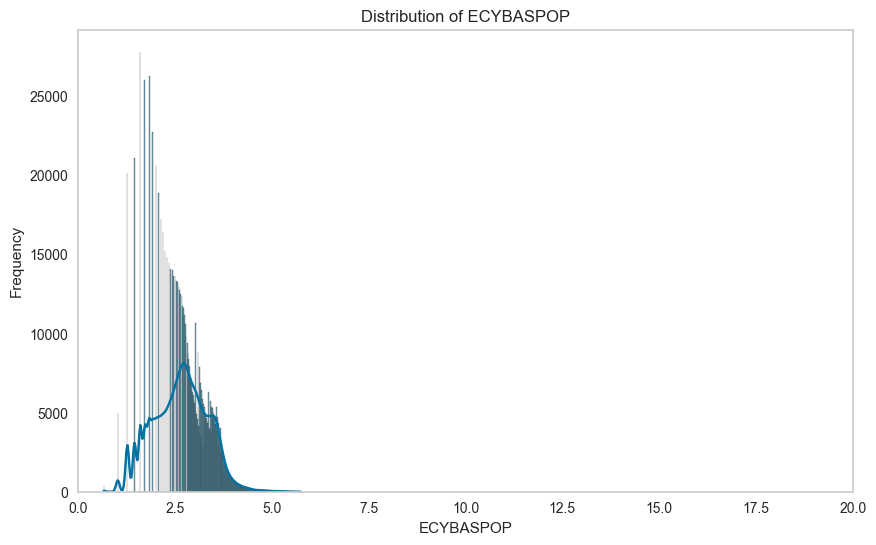

In [17]:
def apply_power_transformer(df: pl.DataFrame) -> pl.DataFrame:
    # Convert to Pandas
    df_pd = df.to_pandas()

    # Identify numeric columns
    numeric_cols = df_pd.select_dtypes(include=[np.number]).columns

    # Apply PowerTransformer to each numeric column
    transformer = PowerTransformer(standardize=False)
    df_pd[numeric_cols] = transformer.fit_transform(df_pd[numeric_cols])

    # Convert back to Polars
    return pl.from_pandas(df_pd)

cleaned_df = apply_power_transformer(merged_df_clust)

plot_distribution(cleaned_df, "ECYBASPOP", xlim=(0, 20), numbins=300)

<h3>Final Statistics</h3>

In [18]:
print(f"Width: {cleaned_df.width}")
print(f"Height: {cleaned_df.height}")

cleaned_df.describe()

Width: 932
Height: 781511


statistic,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,ECYPTA7074,ECYPTA7579,ECYPTA8084,ECYPTA85P,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,…,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0,781511.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2.642738,2.01119,2.901949,2.511875,2.506459,2.643096,2.642604,2.764886,2.73846,2.769411,2.775227,0.779557,2.445562,1.745983,1.686031,1.613587,2.281396,2.642738,0.548149,0.610502,0.652625,0.743194,0.834468,0.818863,0.830132,0.81129,0.817543,0.779086,0.775609,0.804198,0.852887,0.792633,0.657467,0.505078,0.302883,0.200322,…,32.552763,26.892004,26.658309,16.053429,13.685356,25.107186,4.629969,3.593321,3.335178,10.577088,10.288655,8.912245,7.895803,4.370233,8.476851,28.135891,9.121178,15.701729,15.841062,18.148133,3.568148,23.765803,8.651325,11.832242,8.405554,5.261957,7.865804,17.63822,10.327227,8.924371,5.563604,15.948614,3.248157,6.919187,5.445384,5.796541,7.51554
"""std""",0.697305,0.764651,0.884231,0.643547,0.663962,0.805332,0.81372,0.837112,0.834844,0.90326,0.920682,0.519077,0.974138,0.70847,0.696544,0.63248,0.807141,0.697305,0.484591,0.51229,0.496583,0.443681,0.574902,0.560378,0.564495,0.571665,0.572493,0.565605,0.557251,0.564123,0.585608,0.559792,0.501429,0.43471,0.317557,0.251771,…,7.925326,6.682856,6.62086,4.176816,3.748859,6.371248,1.566994,1.372878,1.32174,3.010307,2.959636,2.718099,2.628118,2.103784,2.81428,6.815814,2.334936,4.285528,4.174425,4.569,1.395059,5.772959,2.531687,3.531715,2.372747,1.544469,2.475559,4.827044,3.920962,2.723743,1.977006,4.468348,1.306917,2.115112,1.811924,2.34088,2.368171
"""min""",0.664116,-0.0,-0.0,0.660113,0.661432,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.664116,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
"""25%""",2.137671,1.458419,2.299978,2.032156,2.04567,2.079361,2.084979,2.195738,2.115127,2.155739,2.166336,0.612636,1.858038,1.251785,1.243033,0.982443,1.63695,2.137671,-0.0,-0.0,-0.0,0.602144,0.625258,0.619939,0.620823,0.621086,0.624084,-0.0,-0.0,0.627911,0.634319,-0.0,-0.0,-0.0,-0.0,-0.0,…,27.34259,22.518723,22.329247,13.2862

<p>We can see our data is left with 936 columns and just over 600,000 rows.</p>

<h2>Clustering</h2>
<p>We will be using the KMeans clustering algorithm to cluster the data. We will be using the elbow method, in contrast with the silhouette method to find the optimal number of clusters.</p>

<h3>Scaling</h3>
<p>Scaling will be completed using the RobustScaler, which is a scaler that is robust to outliers. This will help us to scale the data without being affected by the outliers.</p>

In [19]:
# Define the scaler 
scaler = RobustScaler()

# Convert to Pandas DataFrame for scaling
cleaned_df = cleaned_df.to_pandas()

# Fit the scaler to the data
scaler.fit(cleaned_df)

# Transform the data
scaled_data = scaler.transform(cleaned_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=cleaned_df.columns)

scaled_df.head()

,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,...,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
0,0.490100,0.726176,0.536023,0.573640,0.622743,0.633052,0.643176,0.600486,0.598017,0.653035,...,0.538706,-0.633277,-0.131883,1.354670,0.642679,-0.181359,0.684760,0.753889,0.565220,0.242530
1,1.732070,1.773612,1.952824,1.762870,1.817787,1.834554,1.868444,1.934104,1.859312,1.955493,...,1.807289,0.371494,1.400304,2.127561,1.901425,1.135944,1.732648,1.640183,1.496032,1.703557
2,2.204637,2.242592,2.552980,2.174376,2.270035,2.359818,2.402850,2.502197,2.387357,2.556817,...,2.901866,0.880275,2.347310,2.706992,2.999422,1.719530,2.517858,2.265587,2.213731,2.587798
3,1.610819,1.620029,1.801195,1.628930,1.688678,1.687662,1.718297,1.779789,1.710178,1.786385,...,1.650758,0.197692,1.286144,2.003781,1.753350,0.906958,1.559034,1.496559,1.341952,1.521461
4,2.507432,2.616929,2.960535,2.481265,2.599117,2.748549,2.802309,2.934299,2.794747,3.014286,...,3.513830,1.239801,2.862204,3.195873,3.575629,2.194404,3.013776,2.650255,2.663245,3.146885


<h3>Create a sample of the data</h3>
<p>We will create a sample of the data, so that we can run our clustering models faster.</p>

In [20]:
# Sample 20% of the data
sampled_df = scaled_df.sample(frac=0.20, random_state=42)

In [21]:

full_stats = scaled_df.mean()[:5]
sample_stats = sampled_df.mean()[:5]

print("Full Data Means:\n", full_stats)
print("\nSample Data Means:\n", sample_stats)

Full Data Means:
 ECYBASPOP    -0.036321
ECYBASHHD    -0.057494
ECYBASHPOP   -0.009379
ECYBAS12P    -0.019701
ECYBAS15P    -0.017674
dtype: float64

Sample Data Means:
 ECYBASPOP    -0.039042
ECYBASHHD    -0.060454
ECYBASHPOP   -0.012738
ECYBAS12P    -0.022428
ECYBAS15P    -0.020548
dtype: float64


<h3>K-Means Clustering</h3>

<p>Create a K-Means clustering of the data, identifying the optimal number of
clusters using both the silhouette and the elbow method.</p>

<p>Start by using the elbow method to identify the optimal number of clusters.</p>

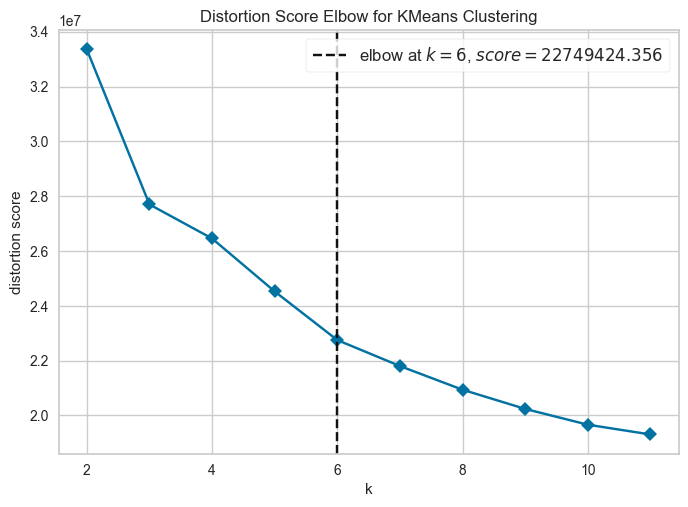

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
# Initialize KClusterer
KClusterer = KMeans(n_clusters=3,
                    verbose=0,
                    random_state=2025)
# Use KElbowVisualizer to find optimal number of clusters
visualizer = KElbowVisualizer(KClusterer, # Cluster model with any parameters you need
                              k=(2,12),   # Number of clusters to test (2 to 12 in this case)
                              locate_elbow=True, # Locate the elbow? Default is true.
                              timings=False # Plot the timings to train?
                             )

visualizer.fit(sampled_df)       # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

<p>We can see the optimal number of clusters is 5, since the knee of the curve is at 5. This is a weak elbow, so we can confirm by using the silouette method.</p>

In [ ]:
# Silhouette Analysis
def plot_silhouette(data, n_clusters):
    # Initialize the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=2025)
    cluster_labels = clusterer.fit_predict(data)

    silhouette_avg = silhouette_score(data, cluster_labels)
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          alpha=0.7)
        plt.text(-0.1, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    plt.title(f"Silhouette plot for {n_clusters} clusters")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

# Run silhouette analysis with optimal clusters
plot_silhouette(sampled_df, 3)

<p>While the distortion elbow suggested five clusters, silhouette analysis showed that a three-cluster solution provided significantly better cohesion and separation, with an average silhouette score of ~0.23. Even though 0.23 is weak, it is still considered acceptable for high-dimensional and real-world demographic data, where perfect separation is rare. The clusters are well-balanced in size, showed no signs of singled groups. Therefore, k=3 is most likely the ideal number of clusters.</p>

<h2>Dimensionality Reduction</h2>

<h3>Apply PCA</h3>

In [ ]:
# Redefine k-clusterer with optimal number of clusters
KClusterer = KMeans(n_clusters=3,
                    verbose=0,
                    random_state=2025)

# Fit the model
cluster_labels = KClusterer.fit_predict(sampled_df)

# Apply PCA to scaled data
pca = PCA(n_components=3)
X_pca = pca.fit_transform(sampled_df)

# Wrap into DataFrame for visualization/analysis
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
pca_df["Cluster"] = cluster_labels

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", s=10)
plt.title("PCA Projection (PC1 vs PC2) Colored by Cluster")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Top contributing features for each component
components = pd.DataFrame(
    pca.components_, 
    columns=scaled_df.columns, 
    index=["PC1", "PC2", "PC3"]
)

for pc in components.index:
    print(f"\n{pc} top features:")
    print(components.loc[pc].abs().sort_values(ascending=False).head(5))

# Average PCA component values by cluster
avg_components_by_cluster = pca_df.groupby("Cluster")[["PC1", "PC2", "PC3"]].mean().reset_index()
print("\nAverage component values by cluster:")
print(avg_components_by_cluster)

<h3>UMAP</h3>
<p>Now we will apply UMAP to reduce the dimensionality of the data.</p>

In [ ]:
# UMAP with commonly good starting values
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.1)
umap_2d = umap_model.fit_transform(sampled_df)

# Create DataFrame
umap_df = pd.DataFrame(umap_2d, columns=["UMAP1", "UMAP2"])
umap_df["Cluster"] = cluster_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="Cluster", palette="tab10", s=10)
plt.title("UMAP Projection Colored by Cluster")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<p>UMAP appears to perform worse than PCA. The clusters are less distinct</p>

<h1>Part 2: Regression</h1>

Now we will create models for a household’s proportion of income spent
on total personal insurance premiums and retirement/pension contributions.

Train a regularized elastic net linear regression from your data.

1. Create your target variable from the variables in the dataset. Do not use
those components on the training database.
2. Apply any data transformation / variable creation you deem necessary to
obtain a good result.
3. Discuss the grid that you chose to search for the parameters and the output
that you obtained.
4. For your test set, create a scatterplot of the original response and the
predicted response. Report the MSE and R2 on the test set and calculate a
bootstrapped confidence interval of the output.
5. Interpret the coefficients of the top five most important variables in the
regression